In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [4]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [5]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...



Done.
Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:232: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.mean(np.log(like))):
/Users/charnock/Physics/delfi/ndes/nde.py:235: RuntimeWarning: divide by zero encountered in log
  return np.mean(np.log(like))


Done.


Saving fish_pretrain_post.pdf


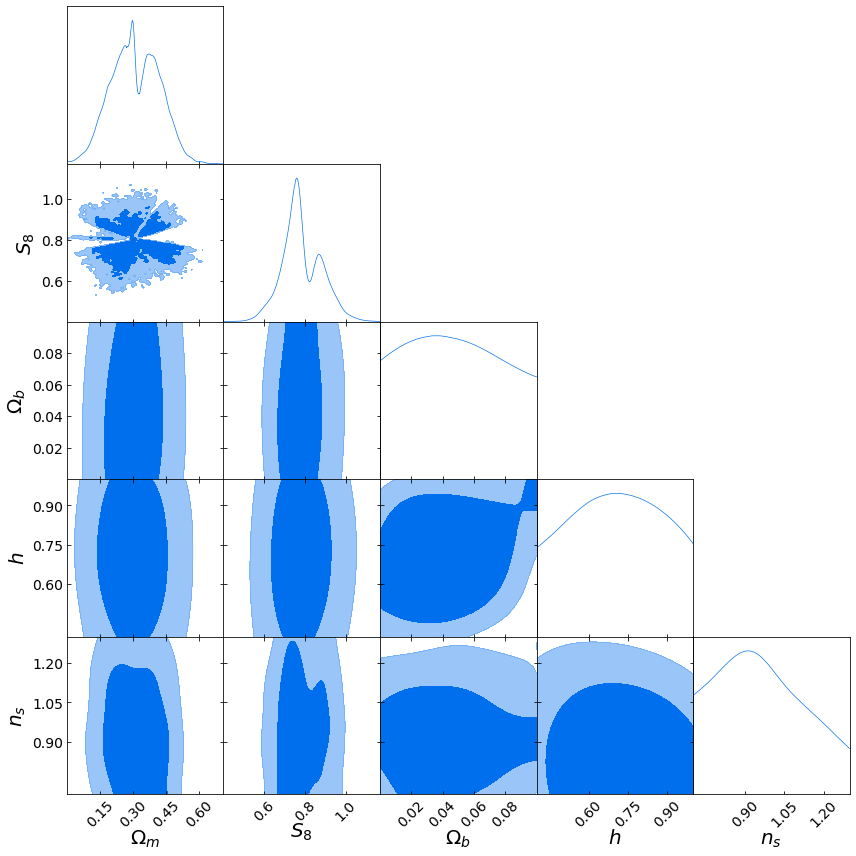

In [8]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=50, epsilon = 1e-37)

In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal, epsilon = 1e-37)

Running initial 500 sims...
Simulator returns exception for parameter values: [0.287872   0.79972294 0.03198945 0.52501646 1.0299754 ] (rank 0)
Simulator returns exception for parameter values: [0.28434937 0.79360663 0.0705683  0.78704449 0.99334172] (rank 0)
Simulator returns exception for parameter values: [0.3107392  0.79839113 0.05117976 0.77186699 0.92018414] (rank 0)
Simulator returns exception for parameter values: [0.30955186 0.7969196  0.02706021 0.54191456 1.00543572] (rank 0)
Simulator returns exception for parameter values: [0.29125605 0.79492596 0.03188935 0.56834755 1.01155257] (rank 0)
Simulator returns exception for parameter values: [0.28766888 0.797214   0.00689374 0.52866159 0.98438445] (rank 0)
Simulator returns exception for parameter values: [0.28705443 0.80260417 0.05466502 0.69105961 0.97042738] (rank 0)
Simulator returns exception for parameter values: [0.29534876 0.80223963 0.02396234 0.64498878 0.92840555] (rank 0)
Simulator returns exception for parameter va

Simulator returns exception for parameter values: [0.29631827 0.80389784 0.04884932 0.81787925 0.87505177] (rank 0)
Simulator returns exception for parameter values: [0.30479666 0.80228993 0.05619776 0.61144985 1.00980439] (rank 0)
Simulator returns exception for parameter values: [0.31855904 0.80353109 0.05904793 0.72533945 0.94259655] (rank 0)
Simulator returns exception for parameter values: [0.28019792 0.79821894 0.04854789 0.7144427  0.96703859] (rank 0)
Simulator returns exception for parameter values: [0.30170551 0.80250052 0.09751806 0.89145296 0.95232677] (rank 0)
Simulator returns exception for parameter values: [0.29239718 0.79754442 0.05686696 0.71812083 0.99290956] (rank 0)
Simulator returns exception for parameter values: [0.32047173 0.80534357 0.0277853  0.47681433 0.99656677] (rank 0)
Simulator returns exception for parameter values: [0.31033329 0.79700798 0.07475923 0.75895989 0.9990256 ] (rank 0)
Simulator returns exception for parameter values: [0.29969485 0.79862065

Simulator returns exception for parameter values: [0.30513969 0.80067638 0.04157062 0.78854224 0.87567772] (rank 0)
Simulator returns exception for parameter values: [0.29572774 0.79399174 0.02927705 0.65936176 0.96486598] (rank 0)
Simulator returns exception for parameter values: [0.28513931 0.79672192 0.03146446 0.4727671  1.08425255] (rank 0)
Simulator returns exception for parameter values: [0.31445038 0.8025887  0.0939309  0.93064917 0.91898308] (rank 0)
Simulator returns exception for parameter values: [0.32229622 0.79286082 0.05343027 0.92625809 0.85736701] (rank 0)
Simulator returns exception for parameter values: [0.30267138 0.80512307 0.06551494 0.83848549 0.88544236] (rank 0)
Simulator returns exception for parameter values: [0.29010449 0.80294775 0.08295941 0.88638777 0.93055868] (rank 0)
Simulator returns exception for parameter values: [0.30079881 0.79942388 0.08728055 0.94607827 0.89688474] (rank 0)
Simulator returns exception for parameter values: [0.29704652 0.80458848

Simulator returns exception for parameter values: [0.29211265 0.80213836 0.00264834 0.57385553 0.91132095] (rank 0)
Simulator returns exception for parameter values: [0.31535592 0.79938725 0.06957933 0.68553893 1.0177128 ] (rank 0)
Simulator returns exception for parameter values: [0.29024221 0.79583805 0.03189398 0.68441936 0.94506084] (rank 0)
Simulator returns exception for parameter values: [0.31470496 0.79948208 0.03718887 0.58140193 0.99763331] (rank 0)
Simulator returns exception for parameter values: [0.30019537 0.79858061 0.02754735 0.65691019 0.93840984] (rank 0)
Simulator returns exception for parameter values: [0.27436374 0.79610101 0.02457933 0.70644911 0.93603945] (rank 0)
Simulator returns exception for parameter values: [0.28826688 0.79931574 0.003487   0.40344069 1.02379468] (rank 0)
Simulator returns exception for parameter values: [0.3098247  0.80020089 0.07943452 0.98520842 0.85697936] (rank 0)
Simulator returns exception for parameter values: [0.30289907 0.80500975

Simulator returns exception for parameter values: [0.30426501 0.80472213 0.04321185 0.68648252 0.93798372] (rank 0)
Simulator returns exception for parameter values: [0.29998666 0.80409303 0.0367304  0.61734823 0.95858213] (rank 0)
Simulator returns exception for parameter values: [0.30964501 0.80423215 0.03682411 0.73085213 0.884797  ] (rank 0)
Simulator returns exception for parameter values: [0.30438715 0.79581932 0.0294303  0.64838064 0.94561994] (rank 0)
Simulator returns exception for parameter values: [0.29593742 0.79777988 0.02556616 0.71059853 0.90081994] (rank 0)
Simulator returns exception for parameter values: [0.3125259  0.80009358 0.04577751 0.67171034 0.9470063 ] (rank 0)
Simulator returns exception for parameter values: [0.3169055  0.80516963 0.02271584 0.6571475  0.89365281] (rank 0)
Simulator returns exception for parameter values: [0.30765564 0.799662   0.02731284 0.62007469 0.94543108] (rank 0)
Simulator returns exception for parameter values: [0.3027562  0.79720417

Simulator returns exception for parameter values: [0.30668928 0.80008629 0.06774756 0.90759048 0.8901347 ] (rank 0)
Simulator returns exception for parameter values: [0.28926195 0.79457559 0.02255069 0.52560602 1.0249516 ] (rank 0)
Simulator returns exception for parameter values: [0.30104826 0.79466177 0.0699185  0.85878484 0.93370575] (rank 0)
Simulator returns exception for parameter values: [0.30517513 0.80372639 0.06692358 0.68333717 0.99482853] (rank 0)
Simulator returns exception for parameter values: [0.2849955  0.7985614  0.00722863 0.42871347 1.03956463] (rank 0)
Simulator returns exception for parameter values: [0.28662226 0.79566317 0.08639863 0.97812296 0.90859639] (rank 0)
Simulator returns exception for parameter values: [0.29450965 0.8013719  0.05718803 0.73514436 0.96571959] (rank 0)
Simulator returns exception for parameter values: [0.3077531  0.79789497 0.05811154 0.72536018 0.96853561] (rank 0)
Simulator returns exception for parameter values: [0.304389   0.80585481

Simulator returns exception for parameter values: [0.30218371 0.7997036  0.03926685 0.69951181 0.92404356] (rank 0)
Simulator returns exception for parameter values: [0.29924592 0.80378763 0.03855373 0.67796417 0.92076404] (rank 0)
Simulator returns exception for parameter values: [3.21738333e-01 8.01370351e-01 1.97815540e-04 5.39194665e-01
 9.16387299e-01] (rank 0)
Simulator returns exception for parameter values: [0.32377516 0.8041112  0.05150367 0.54861838 1.02131926] (rank 0)
Simulator returns exception for parameter values: [0.3130405  0.80287388 0.08549585 0.90880527 0.91029666] (rank 0)
Simulator returns exception for parameter values: [0.29384964 0.79835278 0.0471694  0.70068568 0.96505549] (rank 0)
Simulator returns exception for parameter values: [0.30011329 0.8032173  0.06610074 0.68455967 0.98711195] (rank 0)
Simulator returns exception for parameter values: [0.3064241  0.79879865 0.05137991 0.73902977 0.94372333] (rank 0)
Simulator returns exception for parameter values: [

Simulator returns exception for parameter values: [0.32089029 0.80050061 0.03091271 0.48088615 1.02361092] (rank 0)
Simulator returns exception for parameter values: [0.29463934 0.80288779 0.0745027  0.79444696 0.94634395] (rank 0)
Simulator returns exception for parameter values: [0.28610428 0.79905347 0.01444408 0.46332676 1.02861231] (rank 0)
Simulator returns exception for parameter values: [0.28938485 0.80064799 0.02505143 0.68381904 0.90649569] (rank 0)
Simulator returns exception for parameter values: [0.2910748  0.80370439 0.0373608  0.58307245 0.99017271] (rank 0)
Simulator returns exception for parameter values: [0.30574953 0.80031772 0.06724061 0.87568881 0.91000474] (rank 0)
Simulator returns exception for parameter values: [0.28528027 0.80032638 0.01737852 0.56788463 0.96721033] (rank 0)
Simulator returns exception for parameter values: [0.29632399 0.79624523 0.03219268 0.74204335 0.90630671] (rank 0)
Simulator returns exception for parameter values: [0.30694455 0.79617633

Simulator returns exception for parameter values: [0.29638431 0.80047078 0.03643193 0.47111076 1.05415584] (rank 0)
Simulator returns exception for parameter values: [0.28551405 0.79559861 0.01336986 0.45999472 1.02953524] (rank 0)
Simulator returns exception for parameter values: [0.30640686 0.79721851 0.04084083 0.74538026 0.92908002] (rank 0)
Simulator returns exception for parameter values: [0.29490044 0.7949887  0.01698554 0.64890714 0.93617582] (rank 0)
Simulator returns exception for parameter values: [0.30768692 0.7945193  0.06699179 0.68949544 1.02961544] (rank 0)
Simulator returns exception for parameter values: [0.30395144 0.8006511  0.08491714 0.96822047 0.87901515] (rank 0)
Simulator returns exception for parameter values: [0.28791034 0.79890384 0.04747568 0.74980773 0.94616953] (rank 0)
Simulator returns exception for parameter values: [0.30712401 0.80183572 0.0058087  0.46446466 0.97210262] (rank 0)
Simulator returns exception for parameter values: [0.32561205 0.80278596

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:232: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.mean(np.log(like))):
/Users/charnock/Physics/delfi/ndes/nde.py:235: RuntimeWarning: divide by zero encountered in log
  return np.mean(np.log(like))


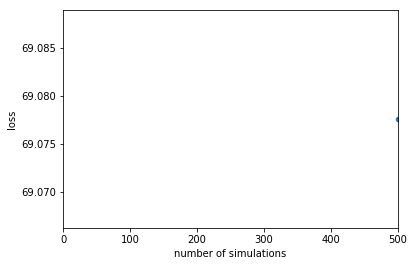

In [10]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()